In [1]:
import time
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import glfw
import keyboard
import math

def action(model, data, left, right):
    data.actuator('right').ctrl[0] = right
    data.actuator('left').ctrl[0] = left

def get_distance(model, data):
    lf = data.sensor('LF').data[0]#sensordata[lf_id]
    ls = data.sensor('LS').data[0]#sensordata[ls_id]
    rs = data.sensor('RS').data[0]#sensordata[rs_id]
    rf = data.sensor('RF').data[0]#sensordata[rf_id]
    return lf,ls,rs,rf

def get_accel(model, data):
  ax = data.sensor('Accel').data[0]
  ay = data.sensor('Accel').data[1]
  az = data.sensor('Accel').data[2]
  return ax,ay,az

def get_gyro(model, data):
  gx = data.sensor('Gyro').data[0]
  gy = data.sensor('Gyro').data[1]
  gz = data.sensor('Gyro').data[2]
  return gx,gy,gz

def get_odom(model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  # vel_right = data.geom('mein_body1').qvel[0]/gear # ＝タイヤの回転角速度
  
  vel_left = data.actuator('left').velocity[0]/gear # ＝タイヤの回転角速度
  # これらは真値のため，エンコーダ4096パルス/1回転ということに考慮すると，1回展あたり4096なので，2pi/4096回るごとにカウントをインクリメントしていく
  return odm_right, odm_left, #vel_right, vel_left

def get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
  """
    回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
    Returns:
        right_pulse_num = 右タイヤのパルス数 \\
          left_pulse_num = 左タイヤのパルス数
    """
  # odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  # odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  global right_rotation_sum
  global left_rotation_sum
  pre_right_rotation_sum = right_rotation_sum
  pre_left_rotation_sum = left_rotation_sum
  right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  # print(right_rotation_sum)
  left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  right_pulse_num = int(right_rotation_sum) - int(pre_right_rotation_sum)
  left_pulse_num = int(left_rotation_sum) - int(pre_left_rotation_sum)
  # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
  return right_pulse_num, left_pulse_num

def get_odom_at_pulse(right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  right_wheel_move = 2*math.pi * wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
  left_wheel_move = 2*math.pi * wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
  right_wheel_vel = right_wheel_move/delta_t #移動距離から，速度を求める
  left_wheel_vel = left_wheel_move/delta_t #移動距離から，速度を求める
  # print(left_wheel_vel)
  mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
  mouse_radvel = (right_wheel_vel - left_wheel_vel)/tread #これがマウスの旋回角速度（rad/s）
  return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた



paused = False
def key_callback(keycode): 
  if chr(keycode) == ' ':
    global paused #グローバル変数のpausedを使用できるように，この関数のスコープ内に取り込む処理
    paused = not paused #pausedの真偽値を逆にする　trueとfalseを反転


def P_straight_control(model, data):#左右の壁による位置補正
    now_speed_left = data.actuator('left').ctrl[0]
    now_speed_right = data.actuator('right').ctrl[0]
    lf, ls, rs, rf = get_distance(model, data)
    
    sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
    # print(sensor_diff)
    left_mot = kp * -sensor_diff + 0.2
    right_mot = kp * sensor_diff + 0.2
    global turn_flag
    if turn_flag==1 or (lf<0.07 and rf <0.07):
        turn_flag = 1
        right_mot =  0.06
        left_mot  = -0.06
        if lf > 0.09 and rf > 0.09:
          turn_flag = 0
    return left_mot, right_mot

def PI_straight_control(model, data):#左右の壁による位置補正
    now_speed_left = data.actuator('left').ctrl[0]
    now_speed_right = data.actuator('right').ctrl[0]
    lf, ls, rs, rf = get_distance(model, data)
    
    sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
    # print(sensor_diff)
    left_mot = kp * -sensor_diff + 0.2
    right_mot = kp * sensor_diff + 0.2
    global turn_flag
    if turn_flag==1 or (lf<0.07 and rf <0.07):
        turn_flag = 1
        right_mot =  0.06
        left_mot  = -0.06
        if lf > 0.09 and rf > 0.09:
          turn_flag = 0
    return left_mot, right_mot

# def odometry():
#    a = 1

# def P_speed(model, data):
#    ax, ay, az = get_accel()



    # if chr(keycode) == ' ':
    #     # 前進の開始時刻を記録
    #     start_time = time.time()
    #     while time.time() - start_time < 0.2:
    #         data.actuator('right').ctrl[0] = 0.3
    #         data.actuator('left').ctrl[0] = 0.3


# 1秒間前進



#Create model
model = mujoco.MjModel.from_xml_path('../mouse_in_maze.xml')
data = mujoco.MjData(model)

odom_right_graph = []
mouse_correct_vel_graph = []

gear = 9.0e-3
wheel_r = 0.0135
tread = 0.072
mx = 0.0
my = 0.0
psi = 0.0
past_odom_right = 0.0
past_odom_left = 0.0
# kp = 100
# st_Kp = 1.55 #ダンピング3.6e-6のときの最適なゲイン
st_Kp = 8.4
rad_Kp = 0.15
rad_vel_Kp = 2

rad_Kd = 0.00001

ki6 = 0.02
kd = 0.09
I_err_sum = 0
d_grad = 0
prev_err_rad = 0
target_vel = 0
target_rad = math.pi/2
target_rad_vel = 0
mjstep_count = 0

right_pulse_num = 0
right_pulse_num_graph = []
left_pulse_num = 0
left_pulse_num_graph = []

right_rotation_sum = 0
left_rotation_sum = 0

mouse_vel = 0
mouse_rad_vel = 0
mouse_xpos = 0
mouse_xpos_graph = []
mouse_ypos = 0
mouse_ypos_graph = []
target_vel_graph = []
err_vel_graph = []
mouse_vel_graph = []

#Get ID
#wheel_left_id = mujoco.mj_name2id(model, 3,'left wheel joint')
#print('#Left Front Sensor ID',  lf_id)

viz_now = 0.0
viz_past = 0.0
now_time = 0
past_time = 0
turn_flag = 0
x_vel = 0
y_vel = 0
z_vel = 0
err = 0
delta_t = 0.01
mouse_now_rad_xy = math.pi/2 #y軸方向を向いている
LRF_lf_graph = []
LRF_ls_graph = []
LRF_rs_graph = []
LRF_rf_graph = []
left_mot = 0 #最初は0
left_mot_graph = []
right_mot = 0
x_vel_graph = []
velocimeter_graph = []
err_graph = []
err_rad_graph = []
gyro_graph = []
yzahyou = []
timevals = []
timevals5 = []
timevals6 = []
I_err_rad_vel_sum = 0
mouse_angle_rad = 0
mouse_angle_rad_graph = []
mouse_correct_rad_vel_graph = []
mouse_rad_vel_graph = []
err_rad_vel_graph = []
target_rad_vel_graph = []

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#Main Loop
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  time.sleep(5)
  left_mot = 0
  right_mot = 0
  for seigyosyuuki2 in range(100):
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = now_time
  print("最初だけI制御をオフにする")
  straight_kp = 16.9
  ki5 = 1*0
  # I_err_sum = 0
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_vel = 0
  for kasoku in range(3):
    target_add_num = [0.15,0,-0.15]
    print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      # print(kukan)
      # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
      # mouse_correct_vel_graph.append(x_veloci)
      target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      I_err_sum += err_vel
      # target_vel_graph.append(target_vel)
      # err_vel_graph.append(err_vel)
      left_mot = straight_kp * err_vel + ki5 * I_err_sum
      right_mot = straight_kp * err_vel + ki5 * I_err_sum
      left_mot_graph.append(left_mot)
      action(model, data, left_mot, right_mot)
      for seigyosyuuki in range(100):
        mujoco.mj_step(model, data)
        mjstep_count += 1
        timevals5.append(data.time)
        mouse_vel_graph.append(mouse_vel)
        yzahyou.append(data.geom("mein_body1").xpos[1])
        err_vel_graph.append(err_vel)
        target_vel_graph.append(target_vel)
        x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
        mouse_correct_vel_graph.append(x_veloci)
        lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
        LRF_lf_graph.append(lf)
        LRF_ls_graph.append(ls)
        LRF_rs_graph.append(rs)
        LRF_rf_graph.append(rf)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad = mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      mouse_xpos_graph.append(mouse_xpos)
      mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      # print("え")
      now_time = data.time
      delta_t = now_time - past_time #past_timeがおかしいことが判明！あとで修正します
      past_time = now_time
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      # LRF_lf_graph.append(lf)
      # LRF_ls_graph.append(ls)
      # LRF_rs_graph.append(rs)
      # LRF_rf_graph.append(rf)
      # time.sleep(3)
      print("lf:",lf, "ls:",ls, "rs:",rs, "rf:",rf)
      # lf: 0.15 ls: 0.07009279563550021 rs: 0.07009279563550021 rf: 0.15
      # 左に壁があるとき

      if ls > 0.09:
        print("左に壁がないとき")
        straight_kp = 16.9
        ki5 = 1*0
        # I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        r_turn_kp = 0.57
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_rad_vel = 0
        for kasoku in range(3):
          target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
          print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
            I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
            left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
            right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals6.append(data.time)
              mouse_rad_vel_graph.append(mouse_rad_vel)
              err_rad_vel_graph.append(err_rad_vel)
              target_rad_vel_graph.append(target_rad_vel)
              # mouse_angle_rad_graph.append(mouse_angle_rad)
              # print(mouse_angle_rad)
              gx, gy, gz = get_gyro(model, data)
              mouse_correct_rad_vel_graph.append(gz)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        straight_kp = 16.9
        ki5 = 1
        I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
      elif lf > 0.18 and rf > 0.18:
        print("前壁に壁がないとき")
        straight_kp = 16.9
        ki5 = 1
        I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        straight_kp = 16.9
        ki5 = 1
        I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
      elif rs > 0.09:
        print("右に壁がないとき")
        straight_kp = 16.9
        ki5 = 1
        I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        
        r_turn_kp = 0.57
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_rad_vel = 0
        for kasoku in range(3):
          target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
          print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
            I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
            left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
            right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals6.append(data.time)
              mouse_rad_vel_graph.append(mouse_rad_vel)
              err_rad_vel_graph.append(err_rad_vel)
              target_rad_vel_graph.append(target_rad_vel)
              # mouse_angle_rad_graph.append(mouse_angle_rad)
              # print(mouse_angle_rad)
              gx, gy, gz = get_gyro(model, data)
              mouse_correct_rad_vel_graph.append(gz)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        straight_kp = 16.9
        ki5 = 1
        I_err_sum = 0
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_vel = 0
        for kasoku in range(3):
          target_add_num = [0.15,0,-0.15]
          print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            # print(kukan)
            # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
            # mouse_correct_vel_graph.append(x_veloci)
            target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
            I_err_sum += err_vel
            # target_vel_graph.append(target_vel)
            # err_vel_graph.append(err_vel)
            left_mot = straight_kp * err_vel + ki5 * I_err_sum
            right_mot = straight_kp * err_vel + ki5 * I_err_sum
            left_mot_graph.append(left_mot)
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals5.append(data.time)
              mouse_vel_graph.append(mouse_vel)
              yzahyou.append(data.geom("mein_body1").xpos[1])
              err_vel_graph.append(err_vel)
              target_vel_graph.append(target_vel)
              x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
              mouse_correct_vel_graph.append(x_veloci)
              lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
              LRF_lf_graph.append(lf)
              LRF_ls_graph.append(ls)
              LRF_rs_graph.append(rs)
              LRF_rf_graph.append(rf)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # print("え")
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
      
      else:
        print("その他の場合")
        r_turn_kp = 0.57
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_rad_vel = 0
        for kasoku in range(3):
          target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
          print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
            I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
            left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
            right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals6.append(data.time)
              mouse_rad_vel_graph.append(mouse_rad_vel)
              err_rad_vel_graph.append(err_rad_vel)
              target_rad_vel_graph.append(target_rad_vel)
              # mouse_angle_rad_graph.append(mouse_angle_rad)
              # print(mouse_angle_rad)
              gx, gy, gz = get_gyro(model, data)
              mouse_correct_rad_vel_graph.append(gz)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
        r_turn_kp = 0.57
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = get_odom(model, data)
        target_rad_vel = 0
        for kasoku in range(3):
          target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
          print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
          for kukan in range(30):
            target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
            err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
            I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
            left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
            right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
            action(model, data, left_mot, right_mot)
            for seigyosyuuki in range(100):
              mujoco.mj_step(model, data)
              mjstep_count += 1
              timevals6.append(data.time)
              mouse_rad_vel_graph.append(mouse_rad_vel)
              err_rad_vel_graph.append(err_rad_vel)
              target_rad_vel_graph.append(target_rad_vel)
              # mouse_angle_rad_graph.append(mouse_angle_rad)
              # print(mouse_angle_rad)
              gx, gy, gz = get_gyro(model, data)
              mouse_correct_rad_vel_graph.append(gz)
            #Vizualize
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            # エンコーダをもう一度読み取る
            odm_right, odm_left = get_odom(model, data)
            # この一瞬に出たパルス数を算出し，
            right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
            right_pulse_num_graph.append(right_pulse_num)
            # パルス数から，移動速度と角速度を求める
            mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
            # mouse_vel_graph.append(mouse_vel)
            # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
            mouse_angle_rad = mouse_rad_vel * delta_t
            mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
            mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
            mouse_xpos_graph.append(mouse_xpos)
            mouse_ypos_graph.append(mouse_ypos)
            # 一つ前のodom値を更新
            pre_odm_right = odm_right
            pre_odm_left = odm_left
            viz_now = data.time
            if viz_now-viz_past>0.01:
              viz_past = viz_now
              viewer.sync()
            now_time = data.time
            delta_t = now_time - past_time
            past_time = now_time
      




      #Simulation

      # if keyboard.is_pressed('5'):#１マス前進
      #   straight_kp = 16.9
      #   ki5 = 1
      #   # エンコーダを読み取る
      #   pre_odm_right, pre_odm_left = get_odom(model, data)
      #   target_vel = 0
      #   for kasoku in range(3):
      #     target_add_num = [0.15,0,-0.15]
      #     print(target_add_num[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
      #     for kukan in range(30):
      #       # print(kukan)
      #       # x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
      #       # mouse_correct_vel_graph.append(x_veloci)
      #       target_vel += target_add_num[kasoku]/30 #目標回転角速度を15度/秒にすると
      #       err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      #       I_err_sum += err_vel
      #       # target_vel_graph.append(target_vel)
      #       # err_vel_graph.append(err_vel)
      #       left_mot = straight_kp * err_vel + ki5 * I_err_sum
      #       right_mot = straight_kp * err_vel + ki5 * I_err_sum
      #       left_mot_graph.append(left_mot)
      #       action(model, data, left_mot, right_mot)
      #       for seigyosyuuki in range(100):
      #         mujoco.mj_step(model, data)
      #         mjstep_count += 1
      #         timevals5.append(data.time)
      #         mouse_vel_graph.append(mouse_vel)
      #         yzahyou.append(data.geom("mein_body1").xpos[1])
      #         err_vel_graph.append(err_vel)
      #         target_vel_graph.append(target_vel)
      #         x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
      #         mouse_correct_vel_graph.append(x_veloci)
      #         lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      #         LRF_lf_graph.append(lf)
      #         LRF_ls_graph.append(ls)
      #         LRF_rs_graph.append(rs)
      #         LRF_rf_graph.append(rf)
      #       #Vizualize
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # エンコーダをもう一度読み取る
      #       odm_right, odm_left = get_odom(model, data)
      #       # この一瞬に出たパルス数を算出し，
      #       right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      #       right_pulse_num_graph.append(right_pulse_num)
      #       # パルス数から，移動速度と角速度を求める
      #       mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      #       # mouse_vel_graph.append(mouse_vel)
      #       # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      #       mouse_angle_rad = mouse_rad_vel * delta_t
      #       mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      #       mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      #       mouse_xpos_graph.append(mouse_xpos)
      #       mouse_ypos_graph.append(mouse_ypos)
      #       # 一つ前のodom値を更新
      #       pre_odm_right = odm_right
      #       pre_odm_left = odm_left
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # print("え")
      #       if keyboard.is_pressed('9'):#PI制御モード
      #         print("breakした")
      #         break
          

        

      #   # 現在の座標変数に移動距離を足して座標更新

      #   # 目標速度値ー現在速度で誤差を求め，その値にPゲインを掛けて制御
      #   # 目標速度値を徐々に上げていく
      #   # 一定
      #   # 徐々に下げていく
      #   # この間オドメトリはし続ける
      #   # 以上ループ

      # elif keyboard.is_pressed('6'):#右90deg回転
      #   r_turn_kp = 0.57
      #   # エンコーダを読み取る
      #   pre_odm_right, pre_odm_left = get_odom(model, data)
      #   target_rad_vel = 0
      #   for kasoku in range(3):
      #     target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
      #     print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
      #     for kukan in range(30):
      #       target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      #       err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      #       I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      #       left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
      #       right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
      #       action(model, data, left_mot, right_mot)
      #       for seigyosyuuki in range(100):
      #         mujoco.mj_step(model, data)
      #         mjstep_count += 1
      #         timevals6.append(data.time)
      #         mouse_rad_vel_graph.append(mouse_rad_vel)
      #         err_rad_vel_graph.append(err_rad_vel)
      #         target_rad_vel_graph.append(target_rad_vel)
      #         # mouse_angle_rad_graph.append(mouse_angle_rad)
      #         # print(mouse_angle_rad)
      #         gx, gy, gz = get_gyro(model, data)
      #         mouse_correct_rad_vel_graph.append(gz)
      #       #Vizualize
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # エンコーダをもう一度読み取る
      #       odm_right, odm_left = get_odom(model, data)
      #       # この一瞬に出たパルス数を算出し，
      #       right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      #       right_pulse_num_graph.append(right_pulse_num)
      #       # パルス数から，移動速度と角速度を求める
      #       mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      #       # mouse_vel_graph.append(mouse_vel)
      #       # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      #       mouse_angle_rad = mouse_rad_vel * delta_t
      #       mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      #       mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      #       mouse_xpos_graph.append(mouse_xpos)
      #       mouse_ypos_graph.append(mouse_ypos)
      #       # 一つ前のodom値を更新
      #       pre_odm_right = odm_right
      #       pre_odm_left = odm_left
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # print("え")
      #       if keyboard.is_pressed('9'):#PI制御モード
      #         print("breakした")
      #         break

      # elif keyboard.is_pressed('7'):#左90deg回転
      #   r_turn_kp = 0.57
      #   # エンコーダを読み取る
      #   pre_odm_right, pre_odm_left = get_odom(model, data)
      #   target_rad_vel = 0
      #   for kasoku in range(3):
      #     target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
      #     print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
      #     for kukan in range(30):
      #       target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      #       err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      #       I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      #       left_mot = -r_turn_kp * err_rad_vel - ki6 * I_err_rad_vel_sum
      #       right_mot = r_turn_kp * err_rad_vel + ki6 * I_err_rad_vel_sum
      #       action(model, data, left_mot, right_mot)
      #       for seigyosyuuki in range(100):
      #         mujoco.mj_step(model, data)
      #         mjstep_count += 1
      #         timevals6.append(data.time)
      #         mouse_rad_vel_graph.append(mouse_rad_vel)
      #         err_rad_vel_graph.append(err_rad_vel)
      #         target_rad_vel_graph.append(target_rad_vel)
      #         # mouse_angle_rad_graph.append(mouse_angle_rad)
      #         # print(mouse_angle_rad)
      #         gx, gy, gz = get_gyro(model, data)
      #         mouse_correct_rad_vel_graph.append(gz)
      #       #Vizualize
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # エンコーダをもう一度読み取る
      #       odm_right, odm_left = get_odom(model, data)
      #       # この一瞬に出たパルス数を算出し，
      #       right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      #       right_pulse_num_graph.append(right_pulse_num)
      #       # パルス数から，移動速度と角速度を求める
      #       mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      #       # mouse_vel_graph.append(mouse_vel)
      #       # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      #       mouse_angle_rad = mouse_rad_vel * delta_t
      #       mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      #       mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      #       mouse_xpos_graph.append(mouse_xpos)
      #       mouse_ypos_graph.append(mouse_ypos)
      #       # 一つ前のodom値を更新
      #       pre_odm_right = odm_right
      #       pre_odm_left = odm_left
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # print("え")
      #       if keyboard.is_pressed('9'):#PI制御モード
      #         print("breakした")
      #         break





      #       # target_rad_vel -= (math.pi/4)/10000 #目標回転角速度を15度/秒にすると
      #       # target_vel += target_add_num[kasoku]/100 #目標回転角速度を15度/秒にすると
      #       # err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      #       # I_err_sum += err_vel
      #       # # target_vel_graph.append(target_vel)
      #       # # err_vel_graph.append(err_vel)
      #       # left_mot = straight_kp * err_vel + ki * I_err_sum
      #       # right_mot = straight_kp * err_vel + ki * I_err_sum
      #       # left_mot_graph.append(left_mot)
      #       # action(model, data, left_mot, right_mot)
      #       # for seigyosyuuki in range(100):
      #       #   mujoco.mj_step(model, data)
      #       #   mjstep_count += 1
      #       #   timevals5.append(data.time)
      #       #   mouse_vel_graph.append(mouse_vel)
      #       #   yzahyou.append(data.geom("mein_body1").xpos[1])
      #       #   err_vel_graph.append(err_vel)
      #       #   target_vel_graph.append(target_vel)
      #       #   x_veloci = data.sensor("Veloci").data[0] # 今の速度を取る
      #       #   mouse_correct_vel_graph.append(x_veloci)
      #       # #Vizualize
      #       # viz_now = data.time
      #       # if viz_now-viz_past>0.01:
      #       #   viz_past = viz_now
      #       #   viewer.sync()
      #       # # エンコーダをもう一度読み取る
      #       # odm_right, odm_left = get_odom(model, data)
      #       # # この一瞬に出たパルス数を算出し，
      #       # right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      #       # right_pulse_num_graph.append(right_pulse_num)
      #       # # パルス数から，移動速度と角速度を求める
      #       # mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      #       # # mouse_vel_graph.append(mouse_vel)
      #       # # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      #       # mouse_angle_rad = mouse_rad_vel * delta_t
      #       # mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      #       # mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      #       # mouse_xpos_graph.append(mouse_xpos)
      #       # mouse_ypos_graph.append(mouse_ypos)
      #       # # 一つ前のodom値を更新
      #       # pre_odm_right = odm_right
      #       # pre_odm_left = odm_left
      #       # viz_now = data.time
      #       # if viz_now-viz_past>0.01:
      #       #   viz_past = viz_now
      #       #   viewer.sync()
      #       # # print("え")
      #       # if keyboard.is_pressed('9'):#PI制御モード
      #       #   print("breakした")
      #       #   break

      # elif keyboard.is_pressed('8'):#左180deg回転
      #   r_turn_kp = 0.57
      #   ki8 = 0.02
      #   # エンコーダを読み取る
      #   pre_odm_right, pre_odm_left = get_odom(model, data)
      #   target_rad_vel = 0
      #   for kasoku in range(3):
      #     target_add_rad_vel = [(-math.pi*5/3),0,(math.pi*5/3)]
      #     print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
      #     for kukan in range(30):
      #       target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      #       err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      #       I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      #       left_mot = -r_turn_kp * err_rad_vel - ki8 * I_err_rad_vel_sum
      #       right_mot = r_turn_kp * err_rad_vel + ki8 * I_err_rad_vel_sum
      #       action(model, data, left_mot, right_mot)
      #       for seigyosyuuki in range(100):
      #         mujoco.mj_step(model, data)
      #         mjstep_count += 1
      #         timevals6.append(data.time)
      #         mouse_rad_vel_graph.append(mouse_rad_vel)
      #         err_rad_vel_graph.append(err_rad_vel)
      #         target_rad_vel_graph.append(target_rad_vel)
      #         # mouse_angle_rad_graph.append(mouse_angle_rad)
      #         # print(mouse_angle_rad)
      #         gx, gy, gz = get_gyro(model, data)
      #         mouse_correct_rad_vel_graph.append(gz)
      #       #Vizualize
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # エンコーダをもう一度読み取る
      #       odm_right, odm_left = get_odom(model, data)
      #       # この一瞬に出たパルス数を算出し，
      #       right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      #       right_pulse_num_graph.append(right_pulse_num)
      #       # パルス数から，移動速度と角速度を求める
      #       mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      #       # mouse_vel_graph.append(mouse_vel)
      #       # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      #       mouse_angle_rad = mouse_rad_vel * delta_t
      #       mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      #       mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      #       mouse_xpos_graph.append(mouse_xpos)
      #       mouse_ypos_graph.append(mouse_ypos)
      #       # 一つ前のodom値を更新
      #       pre_odm_right = odm_right
      #       pre_odm_left = odm_left
      #       viz_now = data.time
      #       if viz_now-viz_past>0.01:
      #         viz_past = viz_now
      #         viewer.sync()
      #       # print("え")
      #       if keyboard.is_pressed('9'):#PI制御モード
      #         print("breakした")
      #         break


      
          
      
      left_mot = 0
      right_mot = 0
      for seigyosyuuki2 in range(100):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
        
      now_time = data.time
      delta_t = now_time - past_time
      ax, ay, az = get_accel(model, data)
    #   err_graph.append(err)
    #   timevals.append(data.time)
    #   x_vel_graph.append(x_vel)
    #   gyro_graph.append(gz)
      before_ax = ax
      before_ay = ay
      before_az = az
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break

      past_time = now_time
      
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

print("end")
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間t(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
plt.plot(timevals5, target_vel_graph, linestyle='solid', label="目標速度[m/s]")
plt.plot(timevals5, mouse_vel_graph, linestyle='solid', label="マウスの推定速度[m/s]")
plt.plot(timevals5, err_vel_graph, linestyle='solid', label="目標速度との誤差")
plt.plot(timevals5, mouse_correct_vel_graph, linestyle='solid', label="実際のマウス速度値[m/s]")

#回転関係のプロット
# plt.plot(timevals6, target_rad_vel_graph, linestyle='solid', label="目標角速度(rad/s)")
# plt.plot(timevals6, mouse_rad_vel_graph, linestyle='solid', label="マウス角速度値(推定)")
# plt.plot(timevals6, err_rad_vel_graph, linestyle='solid', label="目標との角速度誤差")
# plt.plot(timevals6, mouse_correct_rad_vel_graph, linestyle='solid', label="真の角速度")

#壁センサのプロット
# plt.plot(timevals5, LRF_lf_graph, linestyle='solid', label="左前センサ")
# plt.plot(timevals5, LRF_ls_graph, linestyle='solid', label="左センサ")
# plt.plot(timevals5, LRF_rs_graph, linestyle='solid', label="右センサ")
# plt.plot(timevals5, LRF_rf_graph, linestyle='solid', label="右前センサ")


# plt.plot(t, y, label='Free Fall', )
plt.legend(prop={'family':'MS Gothic'})



最初だけI制御をオフにする
0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
lf: 0.3 ls: 0.07009279560816392 rs: 0.2556325488240883 rf: 0.3
前壁に壁がないとき
0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
lf: 0.15092382760975187 ls: 0.0701443028773126 rs: 0.2555613138103157 rf: 0.1509545257402542
右に壁がないとき
0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-0.15 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
lf: 0.14627174060617962 ls: 0.07086646224326269 rs: 0.06961439738624621 rf: 0.14193284090015404
その他の場合
2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
0 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
-2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
2.6179938779914944 ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃

# 関数化してきれいにした↓

最初の１マス進む処理
目標速度： 0.15 ＃＃＃＃＃＃＃＃
目標速度： 0 ＃＃＃＃＃＃＃＃
目標速度： -0.15 ＃＃＃＃＃＃＃＃
end


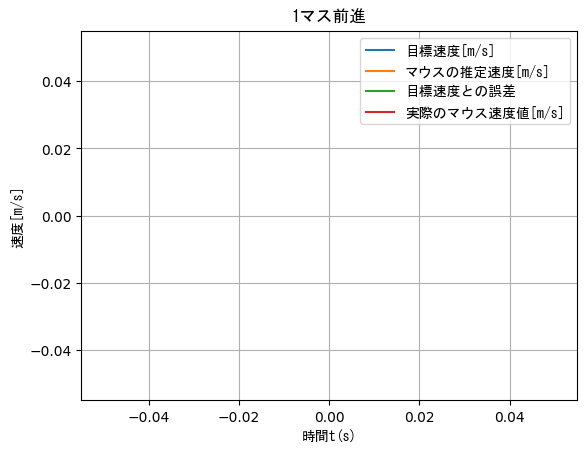

In [1]:
import time
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import glfw
import keyboard
import math

def action(model, data, left, right):
    data.actuator('right').ctrl[0] = right
    data.actuator('left').ctrl[0] = left

def get_distance(model, data):
    lf = data.sensor('LF').data[0]#sensordata[lf_id]
    ls = data.sensor('LS').data[0]#sensordata[ls_id]
    rs = data.sensor('RS').data[0]#sensordata[rs_id]
    rf = data.sensor('RF').data[0]#sensordata[rf_id]
    return lf,ls,rs,rf

def get_accel(model, data):
  ax = data.sensor('Accel').data[0]
  ay = data.sensor('Accel').data[1]
  az = data.sensor('Accel').data[2]
  return ax,ay,az

def get_gyro(model, data):
  gx = data.sensor('Gyro').data[0]
  gy = data.sensor('Gyro').data[1]
  gz = data.sensor('Gyro').data[2]
  return gx,gy,gz

def get_odom(model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  vel_left = data.actuator('left').velocity[0]/gear # ＝タイヤの回転角速度
  return odm_right, odm_left

def get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
  """
    回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
    Returns:
        right_pulse_num = 右タイヤのパルス数 \\
          left_pulse_num = 左タイヤのパルス数
    """
  global right_rotation_sum
  global left_rotation_sum
  pre_right_rotation_sum = right_rotation_sum
  pre_left_rotation_sum = left_rotation_sum
  right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  right_pulse_num = int(right_rotation_sum) - int(pre_right_rotation_sum)
  left_pulse_num = int(left_rotation_sum) - int(pre_left_rotation_sum)
  # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
  return right_pulse_num, left_pulse_num

def get_odom_at_pulse(right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  right_wheel_move = 2*math.pi * wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
  left_wheel_move = 2*math.pi * wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
  right_wheel_vel = right_wheel_move/delta_t #移動距離から，速度を求める
  left_wheel_vel = left_wheel_move/delta_t #移動距離から，速度を求める
  mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
  mouse_radvel = (right_wheel_vel - left_wheel_vel)/tread #これがマウスの旋回角速度（rad/s）
  return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた



paused = False
def key_callback(keycode): #スペースキーで一時停止
  if chr(keycode) == ' ':
    global paused #グローバル変数のpausedを使用できるように，この関数のスコープ内に取り込む処理
    paused = not paused #pausedの真偽値を逆にする　trueとfalseを反転


# def P_straight_control(model, data):#左右の壁による位置補正
#     now_speed_left = data.actuator('left').ctrl[0]
#     now_speed_right = data.actuator('right').ctrl[0]
#     lf, ls, rs, rf = get_distance(model, data)
    
#     sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
#     # print(sensor_diff)
#     left_mot = kp * -sensor_diff + 0.2
#     right_mot = kp * sensor_diff + 0.2
#     global turn_flag
#     if turn_flag==1 or (lf<0.07 and rf <0.07):
#         turn_flag = 1
#         right_mot =  0.06
#         left_mot  = -0.06
#         if lf > 0.09 and rf > 0.09:
#           turn_flag = 0
#     return left_mot, right_mot

#関数化で新しく作成した関数

def mj_step_loop(model, data, loop_num): #mujocoのシミュレーションを任意の数だけ行う関数 グラフ化するときに不便かもしれないから不必要かも
  for i in range(loop_num):
    action(model, data, left_mot, right_mot)#なくても変わらない？？
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    #Vizualize
    viz_now = data.time
    if viz_now-viz_past>0.01:
      viz_past = viz_now
      viewer.sync()

def straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,):#前進0.5マス
  #最初の前進
  straight_kp = kp #デフォルトのゲインにして，変更があったらそれを使う
  straight_ki = ki
  
  I_err_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  target_vel = 0
  past_time = data.time
  # mouse_xpos = 0 #globalにして，引数で受け取ったものに足して言って，戻り値として座標を返すようにすべき？？
  # mouse_ypos = 0
  viz_past = 0 #globalにすべき??
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  for kagennsoku in range(3):
    target_add_num = [0.15,0,-0.15] #各区間での目標速度を入れておくリスト
    print("目標速度：",target_add_num[kagennsoku], "＃＃＃＃＃＃＃＃")
    for mokuhyou_zahyou_kousin in range(30):
      target_vel += target_add_num[kagennsoku]/30 #0から始まって，
      err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      # print("原因説err_vel：", err_vel)
      I_err_sum += err_vel
      left_mot = straight_kp * err_vel + straight_ki * I_err_sum
      right_mot = straight_kp * err_vel + straight_ki * I_err_sum
      action(model, data, left_mot, right_mot)
      # 制御周期を遅くするため，シミュレーションを100回繰り返す
      for seigyosyuuki_delay in range(100):
        mujoco.mj_step(model, data,)
        # lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      #Vizualize　あんまり細かく描画しすぎないように，0.01秒以上経ってたら描画するようにする
      viz_now = data.time
      if viz_now-viz_past>0.1:
        viz_past = viz_now
        viewer.sync()
      
      now_time = data.time
      delta_t = now_time - past_time #シミュレーションが1ステップ終わった後の時間を取得
      past_time = now_time
      # エンコーダをもう一度読み取る　（行動後の値を取得）
      odm_right, odm_left = get_odom(model, data)
      # エンコーダ値から，この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
      # print("関数内は：", mouse_angle_rad)
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t #オドメトリで座標推定
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left 
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left

def right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      for seigyosyuuki in range(100):
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      mouse_xpos_graph.append(mouse_xpos)
      mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left


def left_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      for seigyosyuuki in range(100):
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      mouse_xpos_graph.append(mouse_xpos)
      mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left






#Create model
model = mujoco.MjModel.from_xml_path('../mouse_in_maze.xml')
data = mujoco.MjData(model)

odom_right_graph = []
mouse_correct_vel_graph = []

gear = 9.0e-3
wheel_r = 0.0135
tread = 0.072
mx = 0.0
my = 0.0
psi = 0.0
past_odom_right = 0.0
past_odom_left = 0.0
# kp = 100
# st_Kp = 1.55 #ダンピング3.6e-6のときの最適なゲイン
st_Kp = 8.4
rad_Kp = 0.15
rad_vel_Kp = 2

rad_Kd = 0.00001

ki6 = 0.02
kd = 0.09
I_err_sum = 0
d_grad = 0
prev_err_rad = 0
target_vel = 0
target_rad = math.pi/2
target_rad_vel = 0
mjstep_count = 0

right_pulse_num = 0
right_pulse_num_graph = []
left_pulse_num = 0
left_pulse_num_graph = []

right_rotation_sum = 0
left_rotation_sum = 0

mouse_vel = 0
mouse_rad_vel = 0
mouse_xpos = 0
mouse_xpos_graph = []
mouse_ypos = 0
mouse_ypos_graph = []
target_vel_graph = []
err_vel_graph = []
mouse_vel_graph = []

viz_now = 0.0
viz_past = 0.0
now_time = 0
past_time = 0
turn_flag = 0
x_vel = 0
y_vel = 0
z_vel = 0
err = 0
delta_t = 0.01
mouse_now_rad_xy = math.pi/2 #y軸方向を向いている
I_err_rad_vel_sum = 0
mouse_angle_rad = 0
right_mot = 0
left_mot = 0 #最初は0

#デバッグ用グラフのためのリスト
LRF_lf_graph = []
LRF_ls_graph = []
LRF_rs_graph = []
LRF_rf_graph = []
left_mot_graph = []
x_vel_graph = []
velocimeter_graph = []
err_graph = []
err_rad_graph = []
gyro_graph = []
yzahyou = []
timevals = []
timevals5 = []
timevals6 = []
mouse_angle_rad_graph = []
mouse_correct_rad_vel_graph = []
mouse_rad_vel_graph = []
err_rad_vel_graph = []
target_rad_vel_graph = []

#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#                                                                              
#                                                                           ■■ 
#                      ■                                                    ■ ■
#        ■            ■      ■■            ■  ■                     ■■■■■■■■■■ 
#        ■           ■        ■■           ■■ ■                     ■■■■■■ ■   
#    ■■ ■■         ■■■         ■     ■     ■  ■                            ■   
#     ■■■         ■■■■              ■■     ■  ■                            ■   
#      ■■       ■■  ■■             ■■      ■  ■    ■  ■■■■■■■■■■■         ■    
#     ■■ ■      ■   ■■            ■■       ■  ■   ■                      ■■    
#    ■■   ■         ■■           ■■       ■■  ■  ■■                      ■     
#   ■■              ■■         ■■■        ■   ■■■                      ■■      
#  ■■               ■■        ■          ■     ■                     ■■■       
#                                                                              
#                                                                              
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
#Main Loop
with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(3) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  print("最初の１マス進む処理")
  target_vel = 0
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      

      if ls > 0.09:
        print("左に壁がないとき")
        # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=0,) #0.5マス前進

        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
       
        
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
      elif lf > 0.18 and rf > 0.18:
        print("前壁に壁がないとき")
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
      elif rs > 0.09:
        print("右に壁がないとき", mouse_vel)
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = left_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #左にカーブ
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,) #0.5マス前進
      
      else:
        print("その他の場合")
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #右にカーブ
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05) #右にカーブ


      
      
      left_mot = 0
      right_mot = 0
      for seigyosyuuki2 in range(1000):
        action(model, data, left_mot, right_mot)
        mujoco.mj_step(model, data)
      if keyboard.is_pressed('9'):#PI制御モード
        print("breakした")
        break
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

print("end")
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("時間t(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
plt.plot(timevals5, target_vel_graph, linestyle='solid', label="目標速度[m/s]")
plt.plot(timevals5, mouse_vel_graph, linestyle='solid', label="マウスの推定速度[m/s]")
plt.plot(timevals5, err_vel_graph, linestyle='solid', label="目標速度との誤差")
plt.plot(timevals5, mouse_correct_vel_graph, linestyle='solid', label="実際のマウス速度値[m/s]")

#回転関係のプロット
# plt.plot(timevals6, target_rad_vel_graph, linestyle='solid', label="目標角速度(rad/s)")
# plt.plot(timevals6, mouse_rad_vel_graph, linestyle='solid', label="マウス角速度値(推定)")
# plt.plot(timevals6, err_rad_vel_graph, linestyle='solid', label="目標との角速度誤差")
# plt.plot(timevals6, mouse_correct_rad_vel_graph, linestyle='solid', label="真の角速度")

#壁センサのプロット
# plt.plot(timevals5, LRF_lf_graph, linestyle='solid', label="左前センサ")
# plt.plot(timevals5, LRF_ls_graph, linestyle='solid', label="左センサ")
# plt.plot(timevals5, LRF_rs_graph, linestyle='solid', label="右センサ")
# plt.plot(timevals5, LRF_rf_graph, linestyle='solid', label="右前センサ")


# plt.plot(t, y, label='Free Fall', )
plt.legend(prop={'family':'MS Gothic'})

